# NLP tf-idf pipeline with Apache Spark

In [1]:
%matplotlib inline
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkConf, StorageLevel
from tqdm import tqdm
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover
import pyspark.sql.functions as f
import nltk

In [2]:
# Import other utility functions for benhmarking purposes 
from utils import SimpleTimer, ResultsLogger, visualize_data

## Setting up the spark cluster

In [3]:
conf = (SparkConf().setMaster("local[*]")
                .setAppName("SparkVectorizer")
                .set('spark.driver.memory', '300G')
                .set('spark.driver.maxResultSize', '20G')
                .set('spark.network.timeout', '7200s')
                .set('spark.local.dir', '/raid/tfidf_benchmark/'))
#                .set('spark.executor.cores', '20'))

sc = SparkContext(conf=conf)
sc.setLogLevel("FATAL")
spark = SparkSession(sc)
print(sc._conf.getAll()) # check context settings

21/08/11 08:43:57 WARN Utils: Your hostname, dgx05 resolves to a loopback address: 127.0.0.1; using 10.33.227.155 instead (on interface enp1s0f0)
21/08/11 08:43:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/08/11 08:43:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/08/11 08:43:58 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


[('spark.driver.maxResultSize', '20G'), ('spark.app.id', 'local-1628696639107'), ('spark.driver.host', '10.33.227.155'), ('spark.executor.id', 'driver'), ('spark.driver.port', '42921'), ('spark.local.dir', '/raid/tfidf_benchmark/'), ('spark.app.startTime', '1628696638294'), ('spark.rdd.compress', 'True'), ('spark.network.timeout', '7200s'), ('spark.app.name', 'SparkVectorizer'), ('spark.serializer.objectStreamReset', '100'), ('spark.driver.memory', '300G'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.submit.deployMode', 'client'), ('spark.ui.showConsoleProgress', 'true')]


## Benchmarking Code

### Helper functions

In [4]:
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('english')
PUNCTUATIONS = """[!"#$%&()*+-.\/\\:;<=>?@\[\]^_`{|}\t\n\',~—]"""

def read_data(spark, parquet_path, benchmark=True):
    data = spark.read.parquet(parquet_path, columns=["review_body"])
    if benchmark:
        data.write.format("noop").mode("overwrite").save()
    return data


def text_preprocessor(data, column_name, PUNCTUATIONS, STOPWORDS, benchmark=True):
    data = data.na.drop(subset=[column_name])
    data = data.withColumn(column_name,f.lower(f.col(column_name)))
    data = data.withColumn(column_name,f.regexp_replace(f.col(column_name), PUNCTUATIONS, ' '))
    data = data.withColumn(column_name,f.trim(f.col(column_name)))
    tokenizer = Tokenizer(inputCol=column_name, outputCol="words")
    data = tokenizer.transform(data)                  
    stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords=STOPWORDS)
    data = stopwordsRemover.transform(data)
    if benchmark:
        data.write.format("noop").mode("overwrite").save()
    return data


def hashing_vectorizer(data, benchmark):
    hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=2**20)
    data = hashingTF.transform(data)
    if benchmark:
        data.write.format("noop").mode("overwrite").save()
    return data


def tfidf_transformer(data, benchmark):
    idf = IDF(inputCol="rawFeatures", outputCol="finalFeatures").fit(data)
    data = idf.transform(data)
    if benchmark:
        data.write.format("noop").mode("overwrite").save()
    return data


def execute_full_pipeline(n, i, spark, parquet_path, worker_counts=[1], samples=1, result_path="./results.csv", benchmark=True):
    sample_record = {"overall":0, "data_read":0, "hashing_vectorizer":0, "tfid_transformer":0, "data_preprocessing":0, "nrows":0}
    with SimpleTimer() as timer:
        data = read_data(spark, parquet_path, benchmark)
    sample_record["data_read"]=timer.elapsed/1e9
    print(f"Workers:{n}, Sample Run:{i}, Finished loading data in {sample_record['data_read']}s")

    with SimpleTimer() as timer:
        data = text_preprocessor(data, "review_body", PUNCTUATIONS, STOPWORDS, benchmark)
    sample_record["data_preprocessing"]=timer.elapsed/1e9
    print(f"Workers:{n}, Sample Run:{i}, Finished preprocessing data in {sample_record['data_preprocessing']}s")

    with SimpleTimer() as timer:
        data = hashing_vectorizer(data, benchmark)
    sample_record["hashing_vectorizer"]=timer.elapsed/1e9
    print(f"Workers:{n}, Sample Run:{i}, Finished fitting HashVectorizer in {sample_record['hashing_vectorizer']}s")

    with SimpleTimer() as timer:
        data = tfidf_transformer(data, benchmark=True)
    sample_record["tfidf_transformer"]=timer.elapsed/1e9

    print(f"Workers:{n}, Sample Run:{i}, Finished fitting IDF Transformer in {sample_record['tfidf_transformer']}s")
    return data, sample_record


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nfs/anirband/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def performance_numbers(parquet_path, worker_counts=[1], samples=1, result_path="./results.csv", benchmark=True):
    """
    Main function to perform the performance sweep
    """
    results_logger = ResultsLogger(result_path)    
    for n in worker_counts: 
        for i in tqdm(range(samples)): 
            with SimpleTimer() as overalltimer:
                data, sample_record = execute_full_pipeline(n, i, spark, parquet_path, worker_counts=[1], samples=1, result_path=result_path, benchmark=benchmark)                
            sample_record["overall"]=overalltimer.elapsed/1e9
            sample_record["nrows"]=  data.count()
            sample_record["n_workers"]=n
            sample_record["sample_run"]=i
            print(f"Workers:{n}, Sample Run:{i}, Finished executing full pipeline in {overalltimer.elapsed/1e9}s")
            results_logger.log(sample_record)
    results_logger.write()           

In [6]:
dataset = "Books"
parquet_path = f'/raid/amazon_reviews_dataset/product_category={dataset}'
samples = 5
worker_counts = [1]
result_path = f"./results/result_poc_nlp_spark_{dataset}_persist.csv"

## Benchmark latency by materializing the intermediate dataframe(s) in every stage

In [7]:
%%time
performance_numbers(parquet_path=parquet_path, worker_counts=worker_counts, samples=samples, result_path=result_path, benchmark=True)

Workers:1, Sample Run:0, Finished loading data in 15.23985286s


Workers:1, Sample Run:0, Finished preprocessing data in 107.494748581s


Workers:1, Sample Run:0, Finished fitting HashVectorizer in 202.877945115s


Workers:1, Sample Run:0, Finished fitting IDF Transformer in 487.954867778s


 20%|██████████████████████████████████▌                                                                                                                                          | 1/5 [13:37<54:28, 817.20s/it]

Workers:1, Sample Run:0, Finished executing full pipeline in 813.567748678s


Workers:1, Sample Run:1, Finished loading data in 5.969575999s


Workers:1, Sample Run:1, Finished preprocessing data in 86.506390094s


Workers:1, Sample Run:1, Finished fitting HashVectorizer in 234.087781579s


Workers:1, Sample Run:1, Finished fitting IDF Transformer in 482.773021563s


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                       | 2/5 [27:10<40:44, 814.72s/it]

Workers:1, Sample Run:1, Finished executing full pipeline in 809.337087717s


Workers:1, Sample Run:2, Finished loading data in 4.935677043s


Workers:1, Sample Run:2, Finished preprocessing data in 88.406996062s


Workers:1, Sample Run:2, Finished fitting HashVectorizer in 241.706533445s


Workers:1, Sample Run:2, Finished fitting IDF Transformer in 498.943133027s


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 3/5 [41:07<27:30, 825.11s/it]

Workers:1, Sample Run:2, Finished executing full pipeline in 833.99270305s


Workers:1, Sample Run:3, Finished loading data in 5.483239637s


Workers:1, Sample Run:3, Finished preprocessing data in 90.119382662s


Workers:1, Sample Run:3, Finished fitting HashVectorizer in 235.081407943s


Workers:1, Sample Run:3, Finished fitting IDF Transformer in 498.222800809s


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4/5 [54:59<13:47, 827.96s/it]

Workers:1, Sample Run:3, Finished executing full pipeline in 828.90735261s


Workers:1, Sample Run:4, Finished loading data in 4.991638449s


Workers:1, Sample Run:4, Finished preprocessing data in 86.70907281s


Workers:1, Sample Run:4, Finished fitting HashVectorizer in 248.295504954s


Workers:1, Sample Run:4, Finished fitting IDF Transformer in 480.932740433s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [1:08:44<00:00, 824.89s/it]

Workers:1, Sample Run:4, Finished executing full pipeline in 820.92951352s
CPU times: user 2.29 s, sys: 831 ms, total: 3.12 s
Wall time: 1h 8min 44s


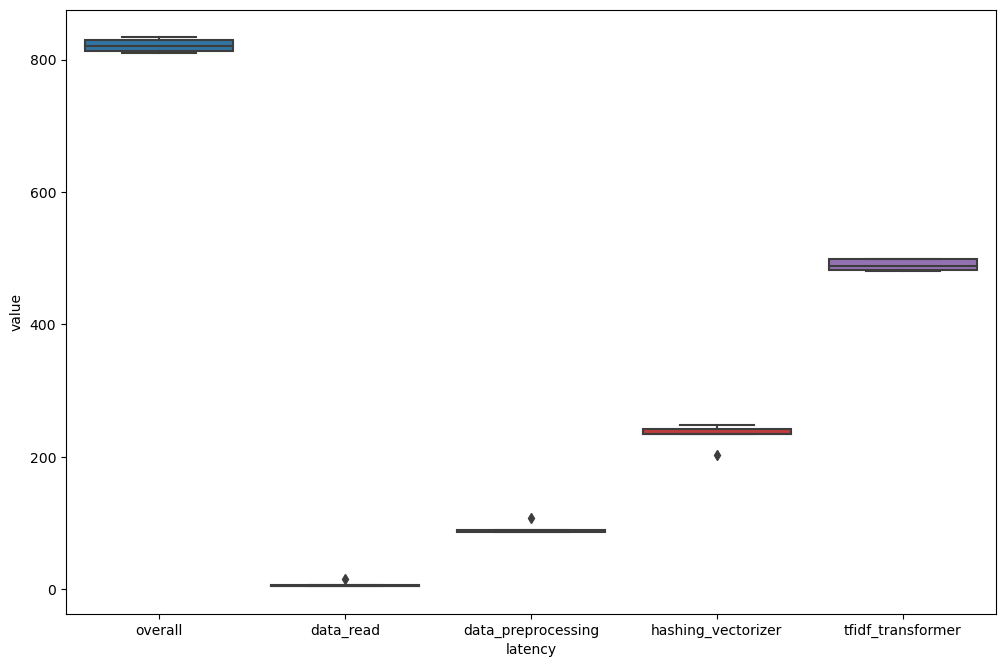

Unnamed: 0                     overall                  data_read  \
                mean       std count        mean        std count      mean   
n_workers                                                                     
1                  2  1.581139     5  821.346881  10.271341     5  7.323997   

                          hashing_vectorizer  ... data_preprocessing  \
                std count               mean  ...              count   
n_workers                                     ...                      
1          4.444873     5         232.409835  ...                  5   

              nrows            tfidf_transformer                 sample_run  \
               mean  std count              mean       std count       mean   
n_workers                                                                     
1          20725971  0.0     5        489.765313  8.454964     5          2   

                           
                std count  
n_workers                  
1          1.581139     5  

[1 rows x 27 columns]

In [8]:
data, melt_data = visualize_data(result_path) 
groupy = data.groupby("n_workers").agg(['mean', 'std', 'count'])
groupy

## Benchmark latency without materializing the intermediate dataframe(s) except for the last stage

In [9]:
dataset = "Books"
parquet_path = f'/raid/amazon_reviews_dataset/product_category={dataset}'
samples = 5
worker_counts = [1]
result_path = f"./results/result_poc_nlp_spark_{dataset}_nonpersist.csv"

In [10]:
%%time
performance_numbers(parquet_path=parquet_path, worker_counts=worker_counts, samples=samples, result_path=result_path, benchmark=False)

  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]

Workers:1, Sample Run:0, Finished loading data in 0.050798674s
Workers:1, Sample Run:0, Finished preprocessing data in 0.09297889s
Workers:1, Sample Run:0, Finished fitting HashVectorizer in 0.012221278s


Workers:1, Sample Run:0, Finished fitting IDF Transformer in 486.358867514s


 20%|██████████████████████████████████▌                                                                                                                                          | 1/5 [08:09<32:39, 489.89s/it]

Workers:1, Sample Run:0, Finished executing full pipeline in 486.515158753s
Workers:1, Sample Run:1, Finished loading data in 0.050539651s
Workers:1, Sample Run:1, Finished preprocessing data in 0.088441056s
Workers:1, Sample Run:1, Finished fitting HashVectorizer in 0.010710309s


Workers:1, Sample Run:1, Finished fitting IDF Transformer in 478.03716527s


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                       | 2/5 [16:11<24:14, 484.95s/it]

Workers:1, Sample Run:1, Finished executing full pipeline in 478.187114776s
Workers:1, Sample Run:2, Finished loading data in 0.050383766s
Workers:1, Sample Run:2, Finished preprocessing data in 0.10429752s
Workers:1, Sample Run:2, Finished fitting HashVectorizer in 0.013528535s


Workers:1, Sample Run:2, Finished fitting IDF Transformer in 493.773125929s


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 3/5 [24:28<16:21, 490.66s/it]

Workers:1, Sample Run:2, Finished executing full pipeline in 493.941810846s
Workers:1, Sample Run:3, Finished loading data in 0.050379153s
Workers:1, Sample Run:3, Finished preprocessing data in 0.08857387s
Workers:1, Sample Run:3, Finished fitting HashVectorizer in 0.011128956s


Workers:1, Sample Run:3, Finished fitting IDF Transformer in 476.473840903s


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4/5 [32:28<08:06, 486.51s/it]

Workers:1, Sample Run:3, Finished executing full pipeline in 476.62420887s
Workers:1, Sample Run:4, Finished loading data in 0.051789292s
Workers:1, Sample Run:4, Finished preprocessing data in 0.088651124s
Workers:1, Sample Run:4, Finished fitting HashVectorizer in 0.010708737s


Workers:1, Sample Run:4, Finished fitting IDF Transformer in 477.363643936s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [40:30<00:00, 486.13s/it]

Workers:1, Sample Run:4, Finished executing full pipeline in 477.515079373s
CPU times: user 1.47 s, sys: 396 ms, total: 1.86 s
Wall time: 40min 30s


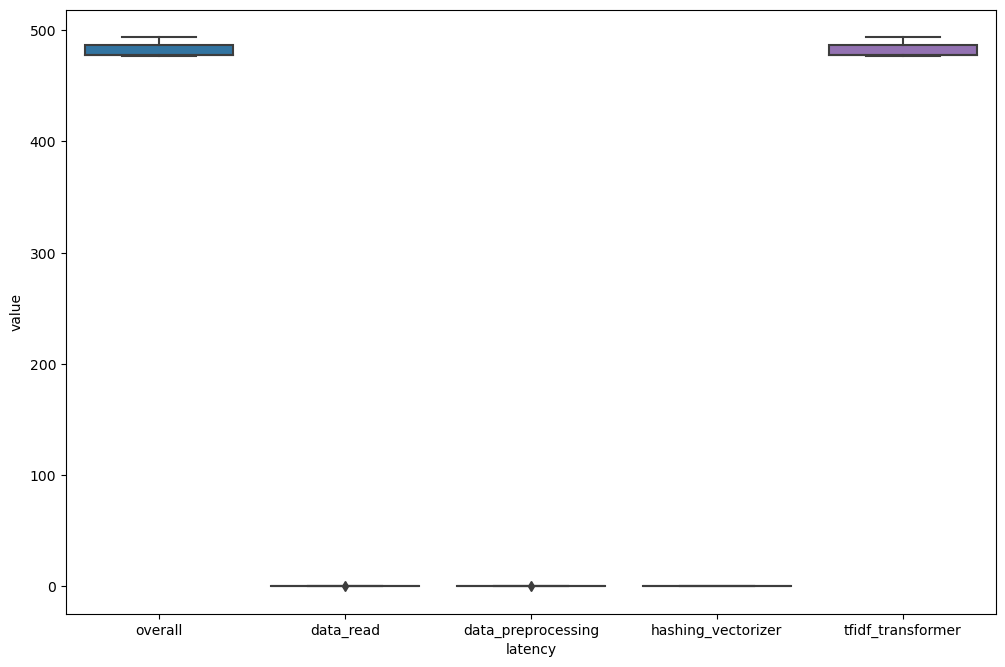

Unnamed: 0                     overall                data_read  \
                mean       std count        mean      std count      mean   
n_workers                                                                   
1                  2  1.581139     5  482.556675  7.49993     5  0.050778   

                         hashing_vectorizer  ... data_preprocessing     nrows  \
               std count               mean  ...              count      mean   
n_workers                                    ...                                
1          0.00059     5            0.01166  ...                  5  20725971   

                     tfidf_transformer                 sample_run            \
           std count              mean       std count       mean       std   
n_workers                                                                     
1          0.0     5        482.401329  7.492316     5          2  1.581139   

                 
          count  
n_workers        
1             5  

[1 rows x 27 columns]

In [11]:
data, melt_data = visualize_data(result_path) 
groupy = data.groupby("n_workers").agg(['mean', 'std', 'count'])
groupy